In [ ]:
# Import necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import graphviz
!pip install dtreeviz
from dtreeviz.trees import dtreeviz

# Import dataset (replace file path with your location, df_u_sample is the 
# second output file from the santander_data_cleaning.ipynb file.)
df_train = pd.read_csv('/content/drive/MyDrive/Santander/df_u_sample.csv')

In [5]:
df_train.head()

,Unnamed: 0,date,customer_code,employee_index,customer_country_residence,customer_sex,age,start_of_relationship,new_customer_6mo,vintage,primary_cust_to_non,last_date_as_primary,customer_type,customer_relation_type,residence_index,foreigner_index,employee_spouse_index,channel_used_to_join,deceased_index,address_type,province_code,province_name,activity_index,gross_household_income,segment,savings_account,guarantees,current_accounts,derivada_account,payroll_account,junior_account,mas_particular_account,particular_account,particular_plus_account,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,retirement,loans,taxes,credit_card,securities,home_account,payroll,pensions,direct_debit,number_of_products
0,13586714,2016-05-28,1232231,N,ES,V,44,2013-12-17,0.0,29,1.0,NaN,1.0,A,S,N,0,KFC,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,4.0
1,12944719,2016-05-28,851478,N,ES,H,38,2009-09-09,0.0,80,1.0,NaN,1.0,I,S,N,0,KAJ,N,1.0,47.0,VALLADOLID,0.0,75079.41,02 - PARTICULARES,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1.0
2,13524683,2016-05-28,1021237,N,ES,H,55,2012-06-28,0.0,47,1.0,NaN,1.0,I,S,N,0,KAT,N,1.0,28.0,MADRID,0.0,215857.77,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1.0
3,12821962,2016-05-28,548190,N,ES,V,52,2005-08-12,0.0,129,1.0,NaN,1.0,I,S,N,0,KEY,N,1.0,11.0,CADIZ,0.0,NaN,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1.0
4,13510795,2016-05-28,1039431,N,ES,H,26,2012-08-01,0.0,45,1.0,NaN,1.0,I,S,N,0,KHE,N,1.0,9.0,BURGOS,0.0,68374.56,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1.0


Some additional data preparation is conducted here to ensure the data is in good shape for modeling. 

In [6]:
# Creating one-hot encoded variables with the channel used to join variable
# Although none of these are ultimately selected by the model and thus not 
# included, they may prove useful in future analysis. 
df_train['channel_kat'] = ['1' if x == 'KAT' 
                           else '0' for x in df_train['channel_used_to_join']]
df_train['channel_kfc'] = ['1' if x == 'KFC' 
                           else '0' for x in df_train['channel_used_to_join']]
df_train['channel_khe'] = ['1' if x == 'KHE' 
                           else '0' for x in df_train['channel_used_to_join']]
df_train['channel_khq'] = ['1' if x == 'KHQ' 
                           else '0' for x in df_train['channel_used_to_join']]
df_train['channel_kfa'] = ['1' if x == 'KFA' 
                           else '0' for x in df_train['channel_used_to_join']]
df_train['channel_khm'] = \
  ['1' if x == 'KHM' else '0' for x in df_train['channel_used_to_join']]

# Remove unusable or redundant columns from dataset 
df_train.drop(['Unnamed: 0', 'date', 'customer_code', 'last_date_as_primary'
                , 'province_code', 'deceased_index', 'start_of_relationship'
                , 'employee_index',  'province_name', 'customer_relation_type'
                , 'channel_used_to_join', 'employee_spouse_index'],
               axis=1, inplace=True)

# Fill NA's of binary variables with 0 
df_train = df_train.apply(lambda x: 
                          x.fillna(0) if x.name in ['payroll', 
                                                    'pensions',
                                                    'employee_spouse_index'] 
                          else x) 

# replace selected columns with "unknown"
df_train = df_train.apply(lambda x: 
                          x.fillna("UNKNOWN") if x.name in ['province_name', 
                                                            'segment'] 
                          else x) 

# select mode of sex and fill in NA's
df_train = df_train.apply(lambda x: 
                          x.fillna(x.value_counts().index[0]) if x.name in 
                          ['customer_sex'] 
                          else x) 

# Code categorical sex indicator to numeric
df_train['customer_sex'] = df_train['customer_sex'].replace({'H':'1','V':'0'})

df_train = df_train.apply(lambda x: 
                          x.replace({'S':'1','N':'0'}) if x.name in 
                          ['customer_sex', 'foreigner_index', 'residence_index'] 
                          else x) 

# Fill gross household income with median value 
df_train['gross_household_income'].fillna(
    df_train['gross_household_income'].median(), inplace=True)

# Code customer segments to numeric 
df_train['segment'] = df_train['segment'].replace({'01 - TOP':'1',
                                                   '02 - PARTICULARES':'2', 
                                                   '03 - UNIVERSITARIO':'3',
                                                   'UNKNOWN': '4'})

# Change customer country into binary indicator
df_train['customer_country_residence'] = \
  ['1' if x == 'ES' else '0' for x in df_train['customer_country_residence']]

# Change datatypes 
df_train["age"] = pd.to_numeric(df_train["age"], errors = 'coerce')

# Conver all columns into numeric
df_train = df_train.apply(pd.to_numeric)

In [7]:
# In the first run of the tree, all of the variables are included.
# Using Grid Search and 10 fold cross validation, the best depth and splitting
#criterion is selected. 

feature_cols = [ 'customer_country_residence','customer_sex','age',
'new_customer_6mo','vintage','primary_cust_to_non','customer_type',
'residence_index','foreigner_index', 'address_type','activity_index',
'gross_household_income','segment','savings_account','guarantees',
'current_accounts', 'derivada_account','payroll_account','junior_account',
'mas_particular_account', 'particular_account','particular_plus_account',
'short_term_deposits', 'medium_term_deposits','long_term_deposits',
'e_account','funds','mortgage','retirement', 'loans','taxes','securities',
'home_account','payroll','pensions','direct_debit', 'number_of_products', 
'channel_kat', 'channel_kfc','channel_khe','channel_khq','channel_kfa',
'channel_khm']

X = df_train[feature_cols] # Features
y = df_train.credit_card # Target variable

# Parameters for grid search are chosen to scan tree combinations from 3 to 20 
# levels and choose between gini and entropy for splitting tree. 
# Cross validation is used with 10 splits in the data.  
parameters = {'max_depth':range(3,20), 'criterion':['gini', 'entropy']}
clf = GridSearchCV(DecisionTreeClassifier(), 
                   parameters, cv=10)
clf.fit(X, y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.7917931339325179 {'criterion': 'gini', 'max_depth': 4}


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


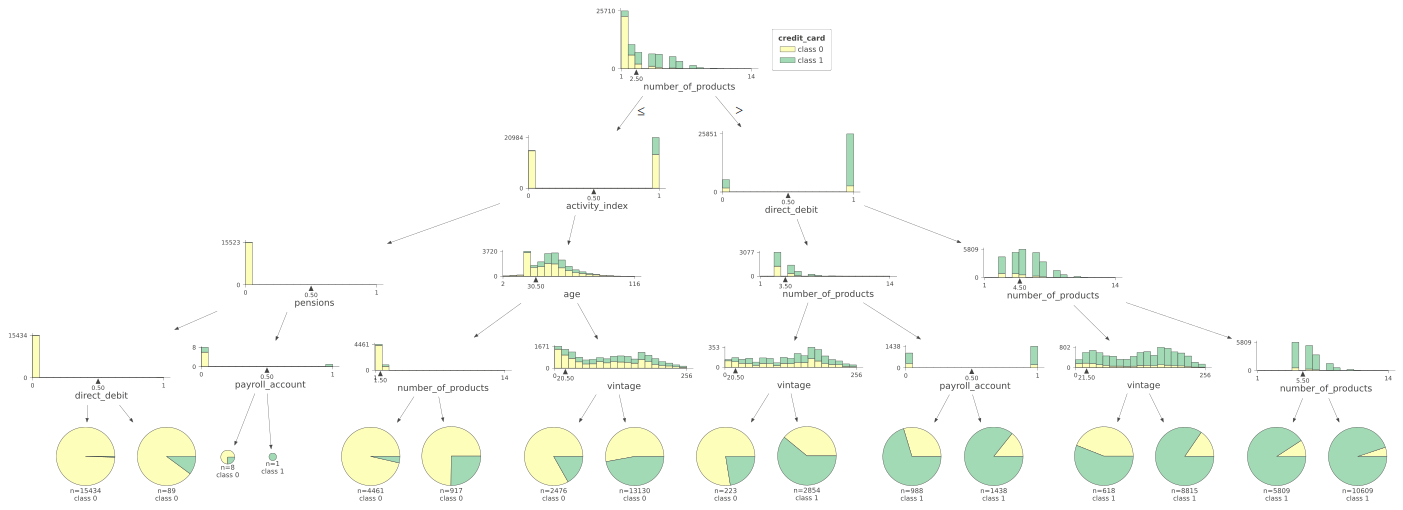

In [8]:
# Visualizing the tree model using the dtreeviz package
viz = dtreeviz(tree_model, X, y,
                target_name="credit_card",
                feature_names=feature_cols
                )
viz

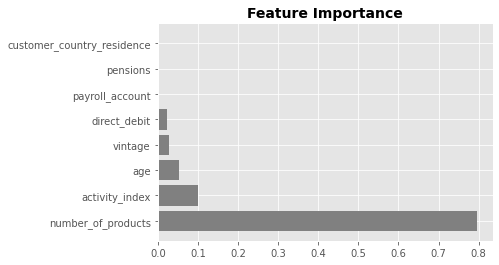

In [9]:
tree_model.feature_importances_

# subset feature importance list
df_feature = pd.DataFrame({'Feature_names': X.columns, 
                           'Importances': tree_model.feature_importances_})
df_feat_graph = df_feature.sort_values(by='Importances', ascending = False)
df_feat_graph = df_feature.nlargest(8, 'Importances')

# Build feature importance graph
plt.style.use('ggplot')
plt.barh(df_feat_graph['Feature_names'], 
         df_feat_graph['Importances'], color='grey' )
plt.title('Feature Importance', color='black', fontweight='bold', fontsize=14)
plt.show()